# Импорт и установка зависимостей

In [2]:
import tensorflow as tf
#!pip install imageio
#!pip install git+https://github.com/tensorflow/docs

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

# Загрузка данных и подготовка

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() # загружаем данные

In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 255) / 255  # Нормализуем изображения

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset\
.from_tensor_slices(train_images)\
.shuffle(BUFFER_SIZE)\
.batch(BATCH_SIZE) # формируем батчи данных

# Построение модели

In [27]:
# формируем архитектуру модели генератора, который будет пытаться воссоздать изображение
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) # подается шум на вход
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256))) # изменяем размерность

    model.add(layers.Conv2DTranspose(filters=128, 
                                     kernel_size=(5, 5), 
                                     strides=(1, 1), 
                                     padding='same', 
                                     use_bias=False)) # делаем upsampling
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(filters=64, 
                                     kernel_size=(5, 5), 
                                     strides=(2, 2), 
                                     padding='same', 
                                     use_bias=False)) # делаем upsampling
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(filters=1, 
                                     kernel_size=(5, 5), 
                                     strides=(2, 2), 
                                     padding='same', 
                                     use_bias=False, 
                                     activation='tanh')) # делаем upsampling

    return model

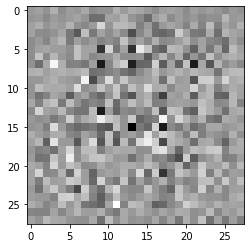

In [10]:
generator = make_generator_model() # инициализируем генератор
noise = tf.random.normal([1, 100]) #  шум
generated_image = generator(noise)  # картинка, генерируемая необученным генератором

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [11]:
# Определяем архитектуру дискриминатора, который будет распознавать оригинальное изображение или нет
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(filters=64, 
                            kernel_size=(5, 5), 
                            strides=(2, 2), 
                            padding='same',
                            input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [13]:
discriminator = make_discriminator_model() # определяем дискриминатор
decision = discriminator(generated_image) # предсказание еще не тренированным дискриминатором
print(decision)

tf.Tensor([[-0.00224282]], shape=(1, 1), dtype=float32)


In [19]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# определим функции потерь генератора и дискриминатора
def discriminator_loss(real_output, fake_output):
    real_loss = loss(tf.ones_like(real_output), real_output) # потери для реальных изображений
    fake_loss = loss(tf.zeros_like(fake_output), fake_output)# потери для фейковых изображений
    total_loss = real_loss + fake_loss # суммарные потери
    return total_loss

def generator_loss(fake_output):
    return loss(tf.ones_like(fake_output), fake_output) # насколько сгенирируемое похоже на реальное

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [20]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt") # путь для сохранения промежуточных результатов
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator) # сохранение промежуточных моделей

In [21]:
# Тренировка модели

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim]) # генерация шума на вход генератору

In [22]:
@tf.function
def train_step(images): # определим шаг обучения
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                    discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, 
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, 
                                                discriminator.trainable_variables))

In [23]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [24]:
def generate_and_save_images(model, epoch, test_input):

    predictions = model(test_input, training=False) # не тренируем слои

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 255 + 255, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
train(train_dataset, EPOCHS)

In [26]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)